# 1) Installations

In [1]:
!pip install torch torchdata
# !pip install transformers==4.35
!pip install transformers datasets
!pip install -q -U bitsandbytes
# !pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -U accelerate
!pip install evaluate rouge_score
!pip install -qqq trl==0.7.1
!pip install loralib

!pip install loralib peft
# !pip install accelerate==0.20.3
!pip install -U accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=229ab6bb16c878fb9c7555f27804c5755db390942ef5200020d5381b4c2644ac
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.0/118.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 4.5 MB/s eta 0:00:00


In [2]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType, PeftModel, PeftConfig
from datasets import load_dataset, DatasetDict, load_metric
import accelerate

import evaluate
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import matplotlib.pyplot as plt


print("torch ver:", torch. __version__ )
# print("transformers ver:", transformers.__version__)
print("accelerate ver:",accelerate.__version__)

torch ver: 2.1.0+cu121
accelerate ver: 0.25.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Running on:', device)

Running on: cuda


In [5]:
seperator_print_short = '-'.join('' for x in range(100))
seperator_print_long = '-'.join('' for x in range(140))

def print_input_outputs(i, index, input, label, model_output):
    print(seperator_print_long)

    print(f"Sample {i+1}: Index = {index}")
    print(seperator_print_short)

    print(f"INPUT:")
    print(input)
    print(seperator_print_short)

    print("DATASET ORIGINAL LABEL:")
    print(label)
    print(seperator_print_short)

    if model_output != "":
        print("OUTPUT OF THE MODEL")
        print(model_output)
        print(seperator_print_short)

    print(seperator_print_long)



# 2) Data Preprocessing & Model Setup

In [6]:
# dataset_src = './arxiv_title_abs_CS_2000.csv'
dataset_src = "/content/drive/MyDrive/datasets/arxiv_title_abs_CS_v2.csv"
dataset_origin = load_dataset('csv',
                       data_files=dataset_src
                       )
dataset_origin

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'title', 'categories', 'abstract'],
        num_rows: 299131
    })
})

In [7]:
dset_train_test = (load_dataset('csv',
                        data_files=dataset_src,
                        split='train'
                        )
          .train_test_split(train_size=0.7)
          )

dset_train_test

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'title', 'categories', 'abstract'],
        num_rows: 209391
    })
    test: Dataset({
        features: ['Unnamed: 0', 'title', 'categories', 'abstract'],
        num_rows: 89740
    })
})

In [8]:
dset_test_val = dset_train_test["test"].train_test_split(train_size=0.75)
# train --> validation
# test --> test
dset_test_val

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'title', 'categories', 'abstract'],
        num_rows: 67305
    })
    test: Dataset({
        features: ['Unnamed: 0', 'title', 'categories', 'abstract'],
        num_rows: 22435
    })
})

In [9]:
dataset = DatasetDict({
                      'train': dset_train_test['train'],
                      'validation': dset_test_val['train'],
                      'test': dset_test_val['test']}
                      )

dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'title', 'categories', 'abstract'],
        num_rows: 209391
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'title', 'categories', 'abstract'],
        num_rows: 67305
    })
    test: Dataset({
        features: ['Unnamed: 0', 'title', 'categories', 'abstract'],
        num_rows: 22435
    })
})

In [10]:
# limit number of samples

dataset['train'] = dataset['train'].shuffle().select([i for i in range(6000)])
dataset['validation'] = dataset['validation'].shuffle().select([i for i in range(1000)])
dataset['test'] = dataset['test'].shuffle().select([i for i in range(250)])
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'title', 'categories', 'abstract'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'title', 'categories', 'abstract'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['Unnamed: 0', 'title', 'categories', 'abstract'],
        num_rows: 250
    })
})

In [11]:
INPUT_COL_NAME = "abstract"
OUTPUT_COL_NAME = "title"

In [12]:
samples_to_check = [10, 15]

for i, index in enumerate(samples_to_check):
    print_input_outputs(i,
                        index,
                        input=dataset['train'][index][INPUT_COL_NAME],
                        label=dataset['train'][index][OUTPUT_COL_NAME],
                        model_output = "")

-------------------------------------------------------------------------------------------------------------------------------------------
Sample 1: Index = 10
---------------------------------------------------------------------------------------------------
INPUT:
  Throughout scientific history, overarching theoretical frameworks have allowed researchers to grow beyond personal intuitions and culturally biased theories. They allow to verify and replicate existing findings, and to link is connected results. The notion of self-play, albeit often cited in multiagent Reinforcement Learning, has never been grounded in a formal model. We present a formalized framework, with clearly defined assumptions, which encapsulates the meaning of self-play as abstracted from various existing self-play algorithms. This framework is framed as an approximation to a theoretical solution concept for multiagent training. On a simple environment, we qualitatively measure how well a subset of the captured 

BNB Config

In [ ]:
# from transformers import BitsAndBytesConfig

# # nested quantization (4bit using NF4 quantization)
# # bnb_4bit_use_double_quant: second quatnization after the
# #                            first one to save add 0.4 bits
# BNB_NF4_CONFIG = BitsAndBytesConfig(
#     load_in_4bit=True,                    # enable 4-bit quantization
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16
# )

Model

In [13]:
# model_id='facebook/bart-base'
model_id='google/flan-t5-base'
# model_id='google/flan-t5-small'
# model_id='lucadiliello/bart-small'

model = AutoModelForSeq2SeqLM.from_pretrained(model_id,
                                              # quantization_config = BNB_NF4_CONFIG,
                                              # device_map = "auto"
                                              )

tokenizer = AutoTokenizer.from_pretrained(model_id,
                                          use_fast=True,
                                          )

# # config tokenizer: assign the eos_token to the pad_token
# tokenizer.pad_token = tokenizer.eos_token
# tokenizer.padding_side = "right"

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [14]:
for i, index in enumerate(samples_to_check):
    abstract = dataset['train'][index][INPUT_COL_NAME]
    title = dataset['train'][index][OUTPUT_COL_NAME]

    inputs = tokenizer(abstract, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"],
            max_new_tokens=25,
        )[0],
        skip_special_tokens=True
    )

    print_input_outputs(i,
                        index,
                        input=abstract,
                        label=title,
                        model_output=output)

-------------------------------------------------------------------------------------------------------------------------------------------
Sample 1: Index = 10
---------------------------------------------------------------------------------------------------
INPUT:
  Throughout scientific history, overarching theoretical frameworks have allowed researchers to grow beyond personal intuitions and culturally biased theories. They allow to verify and replicate existing findings, and to link is connected results. The notion of self-play, albeit often cited in multiagent Reinforcement Learning, has never been grounded in a formal model. We present a formalized framework, with clearly defined assumptions, which encapsulates the meaning of self-play as abstracted from various existing self-play algorithms. This framework is framed as an approximation to a theoretical solution concept for multiagent training. On a simple environment, we qualitatively measure how well a subset of the captured 

## 2.1) Prompt Engineering

Zero-Shot Inference

In [15]:
for i, index in enumerate(samples_to_check):
    abstract = dataset['train'][index][INPUT_COL_NAME]
    title = dataset['train'][index][OUTPUT_COL_NAME]

    prompt=f'''
    Generate a title related to the given abstract:
    {abstract}

    Generated Title:
    '''

    inputs=tokenizer(prompt,return_tensors='pt')
    output=tokenizer.decode(
        model.generate(
            inputs['input_ids'],
            max_new_tokens=512,
        )[0],
        skip_special_tokens=True
    )

    print_input_outputs(i,
                        index,
                        input=prompt,
                        label=title,
                        model_output=output)


-------------------------------------------------------------------------------------------------------------------------------------------
Sample 1: Index = 10
---------------------------------------------------------------------------------------------------
INPUT:

    Generate a title related to the given abstract:
      Throughout scientific history, overarching theoretical frameworks have allowed researchers to grow beyond personal intuitions and culturally biased theories. They allow to verify and replicate existing findings, and to link is connected results. The notion of self-play, albeit often cited in multiagent Reinforcement Learning, has never been grounded in a formal model. We present a formalized framework, with clearly defined assumptions, which encapsulates the meaning of self-play as abstracted from various existing self-play algorithms. This framework is framed as an approximation to a theoretical solution concept for multiagent training. On a simple environment, we

One Shot Inference

In [16]:
def create_one_shot_prompt(base_given_dialogues, test_dialgoue_index):
    prompt='There is an example dialogue with its summary:'

    # add base samples in prompt firstly
    for index in base_given_dialogues:
      abstract = dataset['test'][index][INPUT_COL_NAME]
      title = dataset['test'][index][OUTPUT_COL_NAME]

      prompt+=f"""
              Given abstract:
              {abstract}

              The title of the abstract given above:
              {title}
              """

    # add test abstract
    test_abstract = dataset['test'][test_dialgoue_index][INPUT_COL_NAME]
    prompt+=f"""
              Generate a title related to the given abstract:
              {test_abstract}

              Generated title:
              """
    return prompt


In [17]:
base_given_dialogues=[10]
test_dialgoue_index=20

# input (with one shot prompt)
one_shot_prompt = create_one_shot_prompt(base_given_dialogues, test_dialgoue_index)
print(one_shot_prompt)
print("\n\n\n")

# label
title_new = dataset['test'][test_dialgoue_index][OUTPUT_COL_NAME]

# model output
inputs=tokenizer(one_shot_prompt,return_tensors='pt')
output=tokenizer.decode(
    model.generate(
        inputs['input_ids'],
        max_new_tokens=512,
    )[0],
    skip_special_tokens=True
)

print_input_outputs(i,
                    index,
                    input=one_shot_prompt,
                    label=title_new,
                    model_output=output)


Token indices sequence length is longer than the specified maximum sequence length for this model (554 > 512). Running this sequence through the model will result in indexing errors


There is an example dialogue with its summary:
              Given abstract:
                IEEE 802.11e standard defines two Medium Access Control (MAC) functions to support Quality of Service (QoS) for wireless local area networks: Enhanced Distributed Channel Access (EDCA) and HCF Controlled Channel Access (HCCA). EDCA provides fair prioritized QoS support while HCCA guarantees parameterized QoS for the traffics with rigid QoS requirements. The latter shows higher QoS provisioning with Constant Bit Rate (CBR) traffics. However, it does not efficiently cope with the fluctuation of the Variable Bit Rate (VBR) video streams since its reference scheduler generates a schedule based on the mean characteristics of the traffic. Scheduling based on theses characteristics is not always accurate as these tra_cs show high irregularity over the time. In this paper, we propose an enhancement on the HCCA polling mechanism to address the problem of scheduling pre-recorded VBR video streams. Our ap

In [ ]:
# summary = dataset['test'][test_dialgoue_index]['summary']

# inputs=tokenizer(one_shot_prompt,return_tensors='pt')
# output=tokenizer.decode(
#     model.generate(
#         inputs['input_ids'],
#         max_new_tokens=200,
#     )[0],
#     skip_special_tokens=True
# )
# print(dash_line)
# print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
# print(dash_line)
# print(f'MODEL GENERATION - ONE SHOT:\n{output}')

# 3) Model

## 3.1) Fine Tuning with PEFT

In [18]:
def trainable_model_params(model):
  trainable_params=0
  all_params=0
  for _,param in model.named_parameters():
    all_params+=param.numel()
    if param.requires_grad:
      trainable_params+=param.numel()
  return f"trainable params: {trainable_params}\nall params: {all_params}\npercentage of trainable params: {100*trainable_params/all_params}"
print(trainable_model_params(model))

trainable params: 247577856
all params: 247577856
percentage of trainable params: 100.0


LoRA

In [ ]:
# # # use significantly less GPU memory
# # # activation checkpointing: freeze huge memory with small decrease in training speed
# # model.gradient_checkpointing_enable()

In [ ]:
# # from peft import prepare_model_for_kbit_training

# # # add training adapters
# # model = prepare_model_for_kbit_training(model, use_gradient_checkpointing = True)

In [22]:
LORA_R = 8
LORA_ALPHA = 64         # scaling coefficient for LoRA
LORA_DROPOUT = 0.01

lora_config=LoraConfig(
    r = LORA_R,
    lora_alpha = LORA_ALPHA,
    # target_modules = ["q_proj","v_proj"],
    target_modules=["q", "v"],
    lora_dropout = LORA_DROPOUT,
    bias = "lora_only",                     # check with "none"
    task_type = TaskType.SEQ_2_SEQ_LM
)

# model.enable_input_require_grads()

peft_model=get_peft_model(model,lora_config)

print(trainable_model_params(peft_model))

trainable params: 884736
all params: 248462592
percentage of trainable params: 0.3560841867092814


Tokenizer

In [24]:
def tokenize_function(example):
    START_prompt = 'Generate a relevant title related to the given abstract:'
    END_prompt = '\n\nGenerated Title: '

    prompt = [START_prompt + abstract + END_prompt for abstract in example[INPUT_COL_NAME]]
    example['input_ids'] = tokenizer(prompt,
                                    padding="max_length",
                                    truncation=True,
                                    return_tensors="pt").input_ids

    example['labels'] = tokenizer(example["title"],
                                  padding="max_length",
                                  truncation=True,
                                  return_tensors="pt").input_ids

    return example


tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['title', 'abstract','Unnamed: 0', 'categories'])

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [25]:
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 250
    })
})


PEFT

In [26]:
output_model_name = "t5"
output_config_option = "peft-lora"
output_task = "title-generation"
output_ver = "v1-1"

OUTPUT_DIR = f'./{output_model_name}-{output_config_option}-{output_task}-{output_ver}'

In [27]:
# MAIN PARAMS
NUM_EPOCHS = 6
L_RATE = 2e-4
TRAIN_OPTIMIZER = "paged_adamw_32bit"      # "paged_adamw_32bit"

# OTHER PARAMS
EVAL_STEPS = 0.2
LR_SCHED_TYPE = "cosine"

peft_training_args = TrainingArguments(
    output_dir = OUTPUT_DIR,

    num_train_epochs = NUM_EPOCHS,
    per_device_train_batch_size = 4,
    gradient_accumulation_steps = 2, # accumulating gradients over several batches

    learning_rate = L_RATE,
    optim = TRAIN_OPTIMIZER,
    lr_scheduler_type = LR_SCHED_TYPE,
    # max_grad_norm = 0.4,             # for gradient clipping
    # warmup_ratio = 0.02,             # ratio of total training steps used in [0, LR]

    logging_steps = 4,
    do_train = True,
    do_eval = True,
    evaluation_strategy = "epoch",      # set "steps" to see each val step
    # eval_steps = 4,
    # logging_strategy= "epoch",

    logging_dir = f"{OUTPUT_DIR}/logs",
    # save_strategy = "epoch",

    # load_best_model_at_end = True,
    # save_total_limit=2,
    metric_for_best_model = 'eval_loss',
    save_strategy = "epoch"

)

model.config.use_cache = False

peft_trainer = Trainer(
    model = peft_model,
    args = peft_training_args,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets['validation'],
    # compute_metrics=compute_metrics
    # neftune_noise_alpha=5,             # use NEFTune
    # data_collator=data_collator,
    # max_seq_length=1024,
)

In [28]:
T_START_TRAIN = time.time()
peft_trainer.train()
T_END_TRAIN = time.time()

Epoch,Training Loss,Validation Loss
1,0.110100,0.082300
2,0.089400,0.077186
3,0.082500,0.075563
4,0.094900,0.074766
5,0.086000,0.074481
6,0.099000,0.074469


In [ ]:
# torch.cuda.empty_cache()

In [29]:
PATH_peft_model="./t5-lora-title-generator-checkpoint-1-1"

peft_trainer.model.save_pretrained(PATH_peft_model)
tokenizer.save_pretrained(PATH_peft_model)

('./t5-lora-title-generator-checkpoint-1-1/tokenizer_config.json',
 './t5-lora-title-generator-checkpoint-1-1/special_tokens_map.json',
 './t5-lora-title-generator-checkpoint-1-1/tokenizer.json')

In [30]:
# Load lora model and base LLM model together

peft_model = PeftModel.from_pretrained(model,
                                       PATH_peft_model, #PATH_peft_model
                                       torch_dtype=torch.bfloat16,
                                       is_trainable=False)

Test

In [69]:
TEST_INDEX = 22

abstract = dataset['test'][TEST_INDEX][INPUT_COL_NAME]
title = dataset['test'][TEST_INDEX][OUTPUT_COL_NAME]

prompt = f"""
Generate a title related to the given abstract:
{abstract}

Generated Title:
"""
inputs = tokenizer(prompt, return_tensors='pt')

output_peft = tokenizer.decode(
    peft_model.generate(
        input_ids = inputs['input_ids'].cuda(),
        generation_config = GenerationConfig(max_new_tokens=70,
                                             temperatue=1,
                                             do_sample=True),
    )[0],
    skip_special_tokens = True
)

output_base_model = tokenizer.decode(
    model.generate(
        input_ids = inputs['input_ids'].cuda(),
        generation_config = GenerationConfig(max_new_tokens=70,
                                             temperature=1,
                                             do_sample=True),
    )[0],
    skip_special_tokens = True
)

output_base_model_2 = tokenizer.decode(
    model.generate(
        input_ids = inputs['input_ids'].cuda(),
        generation_config = GenerationConfig( max_new_tokens=1024,
                                              temperature=1,
                                              do_sample=True),
    )[0],
    skip_special_tokens = True
)


print(prompt)
print(seperator_print_short)

print('Label:')
print(title)
print(seperator_print_short)

print('Original Model Summary:')
print(output_base_model)
print(seperator_print_short)

print('PEFT Summary:')
print(output_peft)
print(seperator_print_short)

print('PEFT Summary No Token len:')
print(output_base_model_2)


Generate a title related to the given abstract:
  We develop a hyperparameter optimisation algorithm, Automated Budget Constrained Training (AutoBCT), which balances the quality of a model with the computational cost required to tune it. The relationship between hyperparameters, model quality and computational cost must be learnt and this learning is incorporated directly into the optimisation problem. At each training epoch, the algorithm decides whether to terminate or continue training, and, in the latter case, what values of hyperparameters to use. This decision weighs optimally potential improvements in the quality with the additional training time and the uncertainty about the learnt quantities. The performance of our algorithm is verified on a number of machine learning problems encompassing random forests and neural networks. Our approach is rooted in the theory of Markov decision processes with partial information and we develop a numerical method to compute the value functio

In [ ]:
def get_decoded_prediction(abstract, max_target_length=40):

  inputs = tokenizer(abstract, return_tensors="pt").to(device)
  outputs = model.generate(**inputs, max_new_tokens=max_target_length)
  return tokenizer.decode(outputs[0], skip_special_tokens=True)

result_model_generation = get_decoded_prediction(abstract)
result_model_generation

# 4) Evaluate

In [70]:
peft_model.eval()

PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): T5ForConditionalGeneration(
      (shared): Embedding(32128, 768)
      (encoder): T5Stack(
        (embed_tokens): Embedding(32128, 768)
        (block): ModuleList(
          (0): T5Block(
            (layer): ModuleList(
              (0): T5LayerSelfAttention(
                (SelfAttention): T5Attention(
                  (q): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=False)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.01, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=8, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=8, out_features=768, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
              

In [72]:
metric = evaluate.load("rouge")

def get_decoded_pred_samples(sample, max_target_length=40):
    ## predictions
    # generate summary
    # outputs = model.generate(input_ids=sample["input_ids"].unsqueeze(0).cuda(),
    #                          do_sample=True,
    #                         #  top_p=0.9,
    #                          max_new_tokens=max_target_length)

    outputs = peft_model.generate(input_ids=sample["input_ids"].unsqueeze(0).cuda(),
                             do_sample=True,
                            #  top_p=0.9,
                             max_new_tokens=max_target_length)



    outputs = model.generate(input_ids=sample["input_ids"].unsqueeze(0).cuda(),
                             do_sample=True,
                            #  top_p=0.9,
                             max_new_tokens=max_target_length)


    prediction = tokenizer.decode(outputs[0].detach().cpu().numpy(),
                                  skip_special_tokens=True)

    # Replace -100 in the labels which we can't decode them
    labels = np.where(sample['labels'] != -100,
                      sample['labels'],
                      tokenizer.pad_token_id)


    ## samples
    # decode eval sample
    labels = tokenizer.decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    return prediction, labels


In [73]:
test_dataset = tokenized_datasets['test'].with_format("torch")

df_list_elements = []

T_START_PRED = time.time()
# run predictions
predictions, references, = [] , []
for sample in tqdm(test_dataset):
    pred, y = get_decoded_pred_samples(sample, max_target_length=60)
    predictions.append(pred)
    references.append(y)

    df_list_elements.append([sample, y, pred])


100%|██████████| 250/250 [05:28<00:00,  1.31s/it]


In [74]:
for pred in predictions[:5]:
  print(pred)

Learning a Holomorphic Theory of Adversarial Examples
Using Ambient Tactical Deception in Email Confusing Human Adversarial Intimidation to Motivate Them
An audio tokenization framework based in mel-spectrograms: A review of the findings
Cosine Similarity of Visual Features for Large Data
JANET, a forget-gate-only for long short-term memory: a chrono-initialized gate


In [75]:
# # string manipulation for predictions (delete prompt parts)
predictions_v1 = [pred.replace("Generate a relevant title related to the given abstracte: ", " ") for pred in predictions]
predictions_v2 = [pred.strip() for pred in predictions_v1]
# predictions_v2 = [pred.strip() for pred in predictions]

In [76]:
rogue = metric.compute(predictions=predictions,
                       references=references,
                       use_stemmer=True)
T_END_PRED = time.time()


print(f"Rogue1: {rogue['rouge1']* 100:2f}%")
print(f"rouge2: {rogue['rouge2']* 100:2f}%")
print(f"rougeL: {rogue['rougeL']* 100:2f}%")
print(f"rougeLsum: {rogue['rougeLsum']* 100:2f}%")

Rogue1: 34.282341%
rouge2: 15.487016%
rougeL: 29.761828%
rougeLsum: 29.682001%


In [77]:
df_model_results = pd.DataFrame(df_list_elements,
                                columns=["sample", "label", "prediction"])

df_model_results = df_model_results.drop('sample', axis=1)
df_model_results['prediction'] = df_model_results['prediction'].apply(lambda x: x.replace("Generate a relevant title related to the given abstract: ", " "))
df_model_results['prediction'] = df_model_results['prediction'].apply(lambda x: x.replace("/", ""))
df_model_results['prediction'] = df_model_results['prediction'].apply(lambda x: x.replace("_", ""))
df_model_results['prediction'] = df_model_results['prediction'].apply(lambda x: x.strip())
df_model_results.to_csv('t5_6000_cs_abs_test_results_1.csv')
df_model_results

,label,prediction
0,An Analytic Framework for Robust Training of A...,Learning a Holomorphic Theory of Adversarial E...
1,Manipulation of Perceived Politeness in a Web-...,Using Ambient Tactical Deception in Email Conf...
2,Discrete Audio Representation as an Alternativ...,An audio tokenization framework based in mel-s...
3,A Fast Content-Based Image Retrieval Method Us...,Cosine Similarity of Visual Features for Large...
4,The unreasonable effectiveness of the forget gate,"JANET, a forget-gate-only for long short-term ..."
...,...,...
245,Tracking Initiative in Collaborative Dialogue ...,Estimates for the Transition Transition betwee...
246,Convective transport in nanofluids: the statio...,Matrix of convective transport in nanofluids
247,Real-time Full-stack Traffic Scene Perception ...,A framework for traffic scene perception with ...
248,Logical Step-Indexed Logical Relations,Logical Relationality Modeling for Binary Step...


In [78]:
print("time for training:",T_END_TRAIN - T_START_TRAIN)
print("time for prediction:",T_END_PRED - T_START_PRED)
print("lora r:",LORA_R)
print("lora alpha:",LORA_ALPHA)
print("lora alpha:",LORA_DROPOUT)
print(f"Len Training: {tokenized_datasets['train'].shape}")
print(f"Len Validation: {tokenized_datasets['validation'].shape}")
print(f"Len Test: {tokenized_datasets['test'].shape}")

time for training: 9793.74146771431
time for prediction: 339.44929242134094
lora r: 8
lora alpha: 64
lora alpha: 0.01
Len Training: (6000, 2)
Len Validation: (1000, 2)
Len Test: (250, 2)


In [41]:
df_trainer_logs = pd.DataFrame(peft_trainer.state.log_history)

df_trainer_logs

,loss,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,44.2316,1.999996e-04,0.01,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,39.9561,1.999984e-04,0.01,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,35.7861,1.999965e-04,0.02,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,31.3713,1.999938e-04,0.02,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,28.1403,1.999903e-04,0.03,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,0.0894,1.559637e-09,5.99,4492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1128,0.0869,3.899100e-10,5.99,4496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1129,0.0990,0.000000e+00,6.00,4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1130,NaN,NaN,6.00,4500,0.074469,107.3013,9.32,1.165,NaN,NaN,NaN,NaN,NaN


In [42]:
df_trainer_logs.to_csv('t5_6000_cs_abs_train_logs.csv')

In [43]:
df_trainer_logs = df_trainer_logs[["epoch","loss","eval_loss","learning_rate","step"]]
df_trainer_logs

,epoch,loss,eval_loss,learning_rate,step
0,0.01,44.2316,NaN,1.999996e-04,4
1,0.01,39.9561,NaN,1.999984e-04,8
2,0.02,35.7861,NaN,1.999965e-04,12
3,0.02,31.3713,NaN,1.999938e-04,16
4,0.03,28.1403,NaN,1.999903e-04,20
...,...,...,...,...,...
1127,5.99,0.0894,NaN,1.559637e-09,4492
1128,5.99,0.0869,NaN,3.899100e-10,4496
1129,6.00,0.0990,NaN,0.000000e+00,4500
1130,6.00,NaN,0.074469,NaN,4500


Text(0, 0.5, 'Loss')

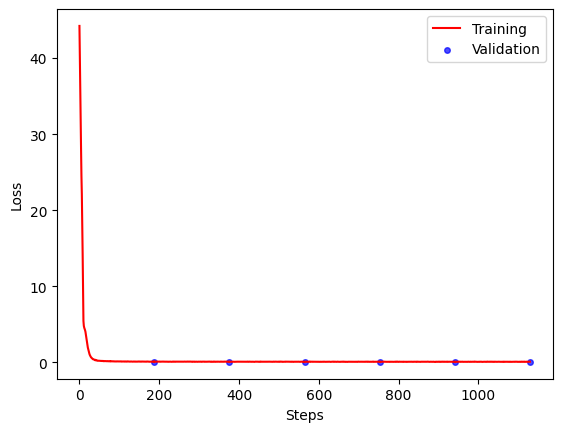

In [44]:
steps = df_trainer_logs.index
train_loss = df_trainer_logs.loss
eval_loss_list = df_trainer_logs.eval_loss

plt.plot(steps, train_loss, label="train_loss", color = "red")
plt.scatter(steps, eval_loss_list,
            c="blue", alpha=0.7, s=16)

plt.legend(["Training", "Validation"], loc ="upper right")
plt.xlabel("Steps")
plt.ylabel("Loss")

In [58]:
!pip install huggingface_hub

In [80]:
peft_model = peft_model.merge_and_unload()

In [84]:
from huggingface_hub import notebook_login
notebook_login()

In [85]:
peft_model.push_to_hub("robuno/title-generation-t5base-6000-v2-1")

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/robuno/title-generation-t5base-6000-v2-1/commit/e810c5f96df9accd9e5b8933b6d38d1e49820957', commit_message='Upload T5ForConditionalGeneration', commit_description='', oid='e810c5f96df9accd9e5b8933b6d38d1e49820957', pr_url=None, pr_revision=None, pr_num=None)

In [86]:
tokenizer.push_to_hub("robuno/title-generation-t5base-6000-v2-1")

CommitInfo(commit_url='https://huggingface.co/robuno/title-generation-t5base-6000-v2-1/commit/81c90530977596b31093a9206adb06c70532bd0d', commit_message='Upload tokenizer', commit_description='', oid='81c90530977596b31093a9206adb06c70532bd0d', pr_url=None, pr_revision=None, pr_num=None)

# 5) Tracking Memory Usage

In [47]:
import locale
print(locale.getpreferredencoding())

ANSI_X3.4-1968


In [49]:
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [53]:
pip install nvidia-ml-py3

  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19171 sha256=6f3831072f2af7a187c2c4e49c6cd56d7e477c0d549d43df1142a6285a927aa0
  Stored in directory: /root/.cache/pip/wheels/5c/d8/c0/46899f8be7a75a2ffd197a23c8797700ea858b9b34819fbf9e
Successfully built nvidia-ml-py3


In [50]:
!nvidia-smi

Sun Dec 31 13:42:47 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0              32W /  70W |  11641MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [51]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Tesla T4
Memory Usage:
Allocated: 1.0 GB
Cached:    11.2 GB


/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:444: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


Merging Models and Upload

In [ ]:
# Empty VRAM
del model
del pipe_titlegen
del trainer
import gc
gc.collect()
gc.collect()